In [4]:
import sys, os, time, shutil, random
from pathlib import Path
_cwd = os.getcwd()
os.chdir(Path(_cwd)/'..')
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))
%load_ext autoreload
%autoreload 2
# %pdb
from itertools import product, cycle
from heapq import heapify, heappush, heappop
import cv2
import omnifig as fig
import numpy as np
import pickle
from tabulate import tabulate
from tqdm.notebook import tqdm
import torch
from torch import nn
import torch.nn.functional as F
import torch.distributions as distrib
import torch.multiprocessing as mp
# import torchvision.models
from torch.utils.data import Dataset, DataLoader, TensorDataset
import networkx as nx

np.set_printoptions(linewidth=120)
torch.set_printoptions(linewidth=200, sci_mode=False)

%matplotlib notebook
import matplotlib.pyplot as plt
#plt.switch_backend('Qt5Agg') #('Qt5Agg')
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
import matplotlib.cm
from matplotlib import animation
import matplotlib as mpl
from matplotlib.collections import PatchCollection
# mpl.rc('image', cmap='gray')
import seaborn as sns
import pandas as pd
from sklearn.preprocessing import normalize

fig.initialize()

import omnilearn as learn
from omnilearn import models
from omnilearn import util
from omnilearn.data import InterventionSamplerBase
from omnilearn import viz as viz_util

from sklearn.cluster import MeanShift, estimate_bandwidth, DBSCAN
from sklearn.datasets import make_blobs
from sklearn.decomposition import PCA

from src import response_mat
# from src.responses import sample_full_interventions

# import gpumap
from c3linearize import linearize, class_graph

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
device = 'cuda'
# device = 'cuda:1'
dataset = None
# figure_root = Path('figures/pres')
figure_root = None
if figure_root is not None and not figure_root.exists():
    figure_root.mkdir()
seed = 10
B = 128
N = 16
G = 32

In [3]:
root = Path('/is/ei/fleeb/workspace/chome/saved_models/lat_resp_models')

In [4]:
run_name = 'mnist_vae1_d-conv_210517-010809'
run_name = '3ds_vae1_d-conv_s1_210523-164722'
run_name = '3ds_vae1_d-conv_d24-s1_210523-164723'

In [5]:
load_config = fig.get_config(path=run_name, root=str(root), **{'override.device':device})
load_config.set_silent(True)
run = fig.run('load-run', load_config)
A = run.get_config()
A.set_silent(True)
info = A.pull('info')
info

{'dataset_type': '3ds',
 'dec_type': 'conv',
 'extra': 'd24-s1',
 'model_type': 'vae',
 'size': 64}

In [6]:
if figure_root is not None:
    figure_dir = figure_root / run_name
    if not figure_dir.exists():
        figure_dir.mkdir()
else:
    figure_dir = None
model = run.get_model()
model.switch_to('val')
model.to(device);
def ae_cycle(q):
    im = model.decode(q.to(device))
    q = model.encode(im)
    if isinstance(q, distrib.Normal):
        q = q.loc
    return im.cpu(), q.cpu()
def encode(x):
    with torch.no_grad():
        q = model.encode(x.to(device))
        if isinstance(q, distrib.Normal):
            q = q.loc
    return q
def decode(q):
    with torch.no_grad():
        return model.decode(q.to(device))
def generate_prior(N, gen=None):
    with torch.no_grad():
        q = torch.randn(N, model.latent_dim, generator=gen).to(device)
        return model.decode(q)
def generate_hybrid(N, gen=None):
    with torch.no_grad():
        return model.generate_hybrid(N)

Hybrid_VAE(
  (encoder): Normal_MultiLayer(
    (layers): ModuleList(
      (0): ConvLayer(
        residual=False
        (conv): Conv2d(3, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
        (pool): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
        (norm): GroupNorm(8, 64, eps=1e-05, affine=True)
        (nonlin): ELU(alpha=1.0, inplace=True)
      )
      (1): ConvLayer(
        residual=False
        (conv): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (pool): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
        (norm): GroupNorm(8, 64, eps=1e-05, affine=True)
        (nonlin): ELU(alpha=1.0, inplace=True)
      )
      (2): ConvLayer(
        residual=False
        (conv): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (pool): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
        (norm): GroupNo

In [1]:
%load_ext autoreload
%autoreload 2
import sys, os
os.environ['PLETHORA_PATH'] = '/is/ei/fleeb/workspace/local_data'
import torch
torch.set_printoptions(linewidth=200, sci_mode=False)
from pathlib import Path
import h5py as hf
from omnibelt import pack, unpack, Packable
import plethora
from plethora.framework.models import Encoder, Decoder, Criterion, Model
from plethora.framework.base import Function
from plethora.framework import features
from plethora.framework.util import spaces, using_rng
from plethora.framework import util as putil
from plethora.framework import MLP, wrapped
from plethora.framework.extractors import Timm_Extractor
from plethora import tasks
from plethora.datasets import SwissRollDataset, MNIST
from plethora import datasets

2022-04-30 18:39:05.728203: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /is/ei/fleeb/miniconda3/lib/python3.8/site-packages/cv2/../../lib64:/is/ei/fleeb/.mujoco/mujoco200/bin
2022-04-30 18:39:05.728218: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
dataset = datasets.Shapes3D(download=False, mode='train')
len(dataset)

384000

In [3]:
dataset.fingerprint()

TypeError: Object of type TransformedBuffer is not JSON serializable

In [ ]:
dataset._fingerprint_data()

In [5]:
torch.Generator().manual_seed(16283393149723337453)

In [1]:
import torch
import numpy as np

In [2]:
torch.manual_seed(1000)

In [3]:
obj = torch.as_tensor([[[-1.0461914539337158, 1.2305212020874023, 1.866212248802185, -0.34353330731391907], [0.06754853576421738, 0.4481339454650879, -0.5985898971557617, 0.2514629662036896], [0.21132567524909973, 0.13313376903533936, 0.25223496556282043, 0.3826902210712433], [0.23442751169204712, 1.1804698705673218, 0.7783403992652893, 1.231757640838623], [0.004945157095789909, 0.11729242652654648, -1.1596639156341553, 0.6123930811882019]], [[0.35184893012046814, 0.186283677816391, 0.9566794633865356, 0.08954408764839172], [0.47332605719566345, -0.7065503597259521, 0.8822028040885925, 0.8555248379707336], [-0.6688796877861023, -0.32016363739967346, 1.3715440034866333, -0.7085981965065002], [0.5169230699539185, -0.37481817603111267, -1.4016997814178467, -0.16504791378974915], [-0.7315189242362976, 2.0900182723999023, 1.696296215057373, -0.04801581799983978]]])

In [4]:
numels = np.product(obj.shape).item()
numels

40

In [5]:
sel = torch.randint(numels, size=(min(5, numels),),
			        generator=torch.Generator().manual_seed(16283393149723337453)).tolist()
sel

[14, 33, 34, 19, 15]

In [6]:
obj.reshape(-1)[sel].tolist()

[0.7783403992652893,
 -0.37481817603111267,
 -1.4016997814178467,
 0.6123930811882019,
 1.231757640838623]

In [21]:
obj.reshape(-1)[sel].tolist()

[0.7783403992652893,
 -0.37481817603111267,
 -1.4016997814178467,
 0.6123930811882019,
 1.231757640838623]

In [8]:
obj.sum().item()

10.199810028076172

In [11]:
import numpy as np
%matplotlib notebook
import matplotlib.pyplot as plt

In [12]:
X, Y = np.mgrid[0:1:120j,0:1:120j]
X.shape, Y.shape

((120, 120), (120, 120))

<IPython.core.display.Javascript object>


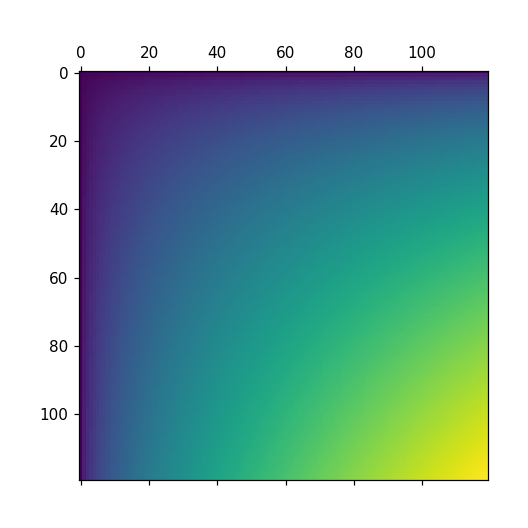

/tmp/ipykernel_9984/3018950272.py:4: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout();


In [17]:
# plt.figure()
plt.matshow(np.sqrt(X*Y))
# plt.matshow(X*Y)
plt.tight_layout();

/tmp/ipykernel_9984/3938141952.py:1: RuntimeWarning: invalid value encountered in true_divide
  plt.matshow(X*Y*2 / (X+Y))


<IPython.core.display.Javascript object>


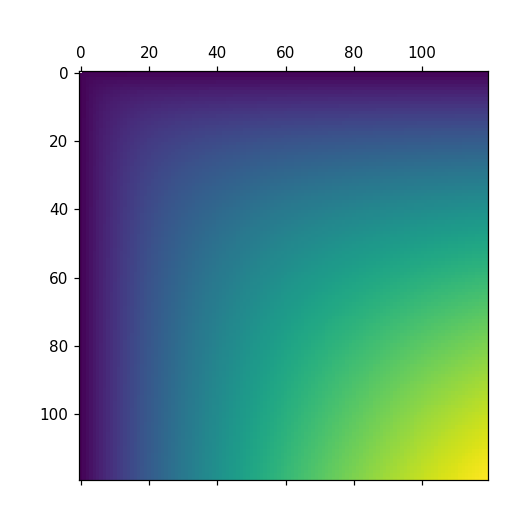

/tmp/ipykernel_9984/3938141952.py:3: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout();


In [20]:
plt.matshow(X*Y*2 / (X+Y))
# plt.matshow(X*Y)
plt.tight_layout();

/tmp/ipykernel_9984/2182166151.py:2: RuntimeWarning: invalid value encountered in true_divide
  plt.matshow(X*Y*2 / (X+Y) - np.sqrt(X*Y))


<IPython.core.display.Javascript object>


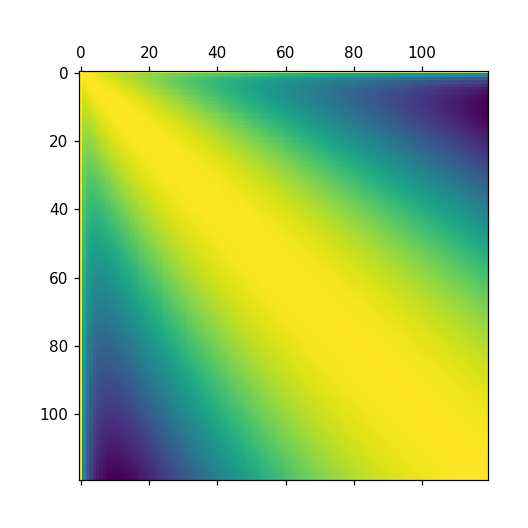

/tmp/ipykernel_9984/2182166151.py:4: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout();


In [19]:
# plt.figure()
plt.matshow(X*Y*2 / (X+Y) - np.sqrt(X*Y))
# plt.matshow(X*Y)
plt.tight_layout();

In [7]:
N = 1000

In [13]:
torch.randint(N, size=(min(5,N),), generator=dataset.create_rng(seed=-3787762104584831759))

tensor([931, 426, 449, 514, 660])

In [6]:
dataset.gen_random_seed()

[autoreload of plethora.datasets.base failed: Traceback (most recent call last):
  File "/is/ei/fleeb/miniconda3/lib/python3.8/site-packages/IPython/extensions/autoreload.py", line 245, in check
    superreload(m, reload, self.old_objects)
  File "/is/ei/fleeb/miniconda3/lib/python3.8/site-packages/IPython/extensions/autoreload.py", line 394, in superreload
    module = reload(module)
  File "/is/ei/fleeb/miniconda3/lib/python3.8/imp.py", line 314, in reload
    return importlib.reload(module)
  File "/is/ei/fleeb/miniconda3/lib/python3.8/importlib/__init__.py", line 169, in reload
    _bootstrap._exec(spec, module)
  File "<frozen importlib._bootstrap>", line 604, in _exec
  File "<frozen importlib._bootstrap_external>", line 779, in exec_module
  File "<frozen importlib._bootstrap_external>", line 916, in get_code
  File "<frozen importlib._bootstrap_external>", line 846, in source_to_code
  File "<frozen importlib._bootstrap>", line 219, in _call_with_frames_removed
  File "/is/ei/f

-3787762104584831759

In [2]:
dataset = datasets.Shapes3D(download=False, mode='train')
len(dataset)
dataset.prepare();

In [14]:
seed = 10

In [15]:
# dataset = MNIST(seed=seed, batch_size=100)
len(dataset), dataset.din, dataset.dout

(384000,
 Pixels(C=3, H=64, W=64),
 Joint(Periodic(1), Periodic(1), Periodic(1), Bound(min=0.75, max=1.25), Categorical(4), Bound(min=-30, max=30)))

In [16]:
extractor = Timm_Extractor('mobilenetv3_large_100', din=dataset.observation_space)
# extractor
extractor.din, extractor.dout

(Pixels(C=3, H=64, W=64), Unbound(1280))

In [17]:
dataset.prepare();

In [18]:
batch = dataset.get_batch()
len(batch)

64

In [19]:
obs = batch.get('observation')
obs.shape

torch.Size([64, 3, 64, 64])

In [20]:
with torch.no_grad():
    feats = extractor.extract(obs)
feats.shape

torch.Size([64, 1280])

<IPython.core.display.Javascript object>


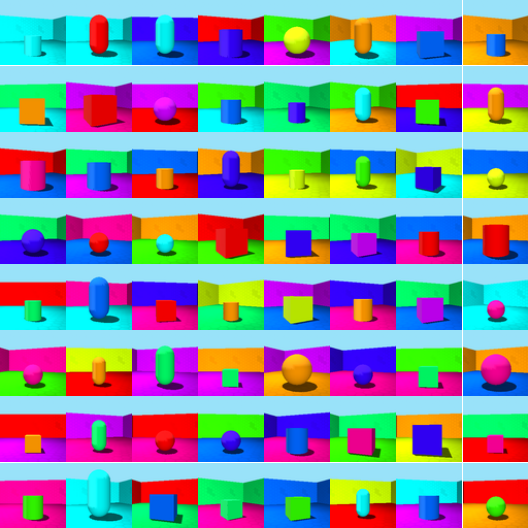

In [21]:
util.plot_imgs(obs);

In [22]:
z = encode(obs)
z.shape

torch.Size([64, 24])

In [23]:
spaces.Pixels(*model.dout)

Pixels(C=3, H=64, W=64)

In [24]:
# dataset2 = dataset.copy()

In [25]:
# from plethora.tasks.inference import GradientBoostingWrapperBuilder
# class NonPeriodizedBuilder(GradientBoostingWrapperBuilder):
# 	def create_regressor(self, din, dout):
# 		return self.create_sequential(din, dout)

In [26]:
enc = wrapped.Encoder(encode, din=spaces.Pixels(*model.din), din_device=device,
                      dout=spaces.Unbound(model.latent_dim), dout_device='cpu')
dec = wrapped.Decoder(decode, dout=spaces.Pixels(*model.din), din_device=device,
                      din=spaces.Unbound(model.latent_dim), dout_device='cpu')

In [27]:
vals = []

In [28]:
# task = tasks.ReconstructionTask(dataset=dataset, 
#                                 encoder=enc, decoder=dec, criterion_name='ms-ssim',
#                          num_samples=1000, batch_size=100, pbar=tqdm)

# model.generate = generate_prior
# task = tasks.PR_GenerationTask(dataset=dataset, pbar=tqdm, 
#                                num_samples=10000, batch_size=100,
#                                generator=model, extractor=extractor)


# task = tasks.InferenceTask(dataset=dataset, pbar=tqdm, num_samples=1000, batch_size=100, batch_device='cuda',
#                            encoder=enc, 
# #                            builder=NonPeriodizedBuilder(),
#                           )

sigfigs = 2
# task = tasks.RoundingCompressionTask(dataset=dataset, pbar=tqdm, num_samples=1000, batch_size=100, memory_weight=1.,
#                                      sigfigs=sigfigs, compressor_name='lzma', criterion_name='ms-ssim',
#                                      encoder=enc, decoder=dec)

# task = tasks.LossyCompressionTask(dataset=dataset, pbar=tqdm, num_samples=1000, batch_size=100,
#                                   criterion_name='ms-ssim', 
#                                  compressor=tasks.SigfigCompressor(sigfigs=sigfigs, compressor_name='lzma'))


# task = tasks.BitsBackCompressionTask(dataset=dataset, pbar=tqdm, num_samples=20, batch_size=4,
#                                      encoder=enc, decoder=dec, strict_verify=False)

# task = tasks.LosslessCompressionTask(dataset=dataset, pbar=tqdm, num_samples=1000, batch_size=100,
#                                   compressor_name='lzma')

task = tasks.CorrelationMetricTask(dataset=dataset, pbar=tqdm, metric_name='l2',
	                          num_samples=1000, batch_size=100,
	                          encoder=enc)

In [ ]:
# with torch.no_grad():
#     out = task.compute(batch)
# out['score']

In [ ]:
# out.keys()

In [30]:
with torch.no_grad():
    out = task.compute()
out['score']

  0%|          | 0/1000 [00:00<?, ?it/s]

0.714570939540863

In [34]:
out.keys()

odict_keys(['observation', 'latent', 'a', 'b', 'distance', 'measure', 'target', 'label_a', 'label_b', 'true_distance', 'true_measure', 'errors', 'batch_cross_correlation', 'batch_modularity', 'batch_compactness', 'full_errors', 'mean', 'max', 'min', 'std', 'full_distance', 'full_true_distance', 'full_batch_cross_correlation', 'cross_correlation_mean', 'cross_correlation_max', 'cross_correlation_min', 'cross_correlation_std', 'full_batch_modularity', 'modularity_mean', 'modularity_max', 'modularity_min', 'modularity_std', 'full_batch_compactness', 'compactness_mean', 'compactness_max', 'compactness_min', 'compactness_std', 'cross_correlation', 'modularity', 'compactness', 'score'])

<IPython.core.display.Javascript object>


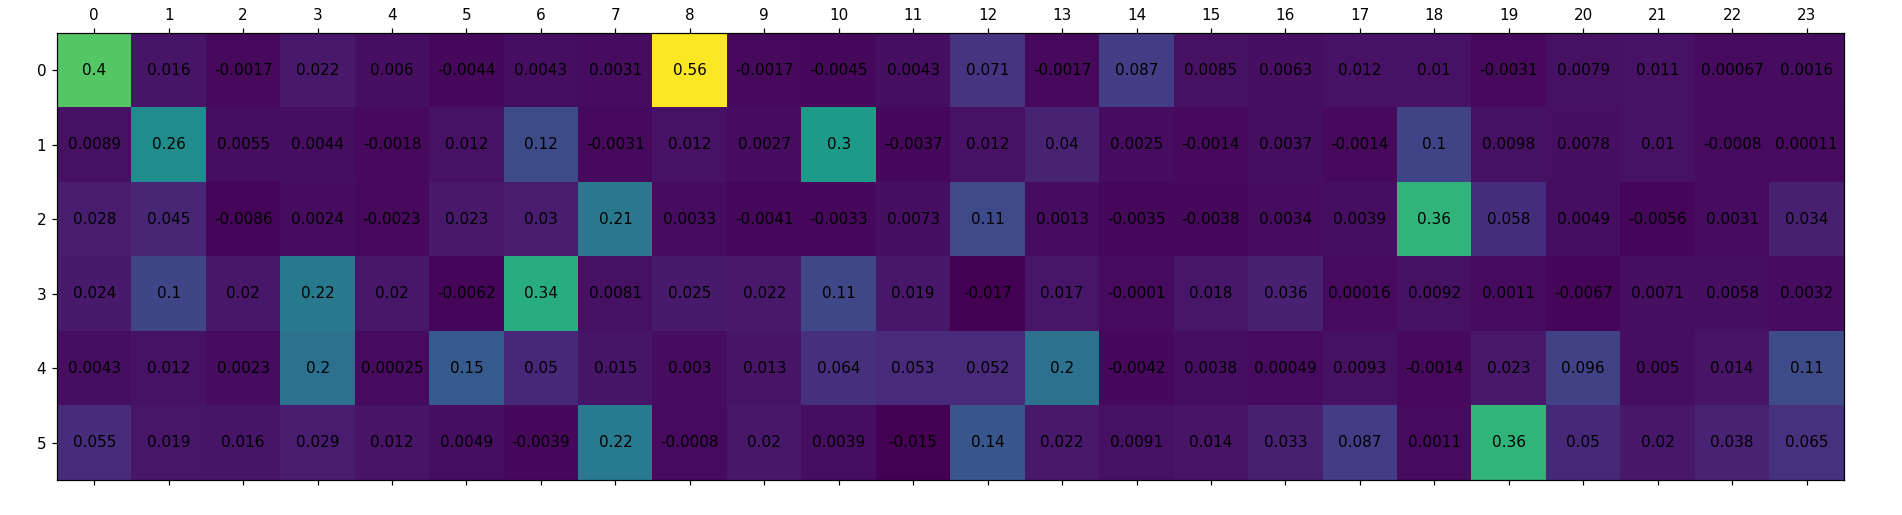

In [31]:
util.plot_mat(out['cross_correlation_mean'], val_fmt=2);

In [37]:
Mat = out['cross_correlation_mean']

In [38]:
from plethora import util as putil

In [33]:
d = out['distance']

In [34]:
t = out['true_distance']

In [35]:
d = d/d.norm()
t = t/t.norm()
d.shape, t.shape

(torch.Size([4950]), torch.Size([4950]))

In [36]:
d

tensor([0.0116, 0.0145, 0.0165,  ..., 0.0137, 0.0165, 0.0152])

In [37]:
t

tensor([0.0051, 0.0078, 0.0206,  ..., 0.0122, 0.0200, 0.0176])

In [38]:
order = d.sort(0)[1]

<IPython.core.display.Javascript object>


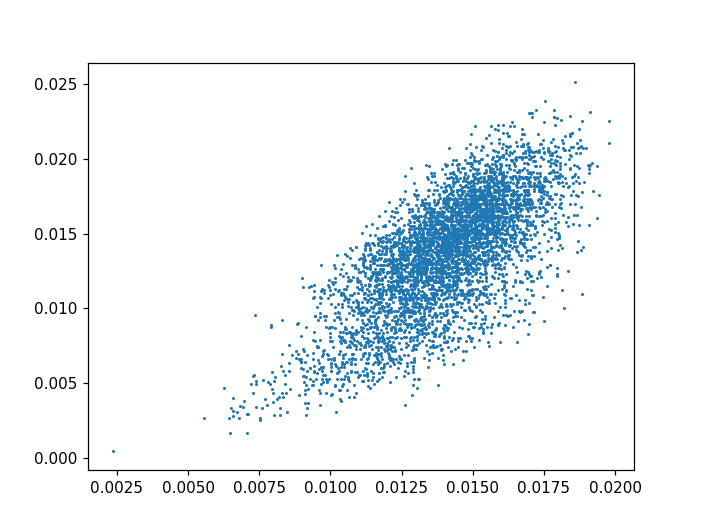

In [39]:
plt.figure()
# plt.plot(d[order],t[order])
plt.plot(d,t, ls='', marker='.', ms=2);

In [48]:
def corrcoef(target, pred):
    # np.corrcoef in torch from @mdo
    # https://forum.numer.ai/t/custom-loss-functions-for-xgboost-using-pytorch/960
    pred_n = pred - pred.mean()
    target_n = target - target.mean()
    pred_n = pred_n / pred_n.norm()
    target_n = target_n / target_n.norm()
    return (pred_n * target_n).sum()


def spearman(
    target,
    pred,
    regularization="l2",
    regularization_strength=1.0,
):
    # fast_soft_sort uses 1-based indexing, divide by len to compute percentage of rank
    pred = soft_rank(
        pred,
        regularization=regularization,
        regularization_strength=regularization_strength,
    )
    return corrcoef(target, pred / pred.shape[-1])

In [50]:
from scipy import stats

In [92]:
N = 20
x, y = torch.randn(1,N),torch.randn(1, N)

In [93]:
Nx, Ny = len(x), len(y)

In [94]:
rho, pval = stats.spearmanr(x.numpy(),y.numpy(), axis=1)
rho.shape

()

In [95]:
rho

-0.019548872180451125

In [96]:
r, p = stats.spearmanr(x[:1].numpy(),y.numpy(), axis=1)
r

-0.019548872180451125

In [97]:
R = torch.from_numpy(rho[Nx:Nx+Ny,:Nx]).float()

IndexError: invalid index to scalar variable.

In [91]:
R.diag()

tensor([0.1489, 0.1203])

In [99]:
x = torch.randn(3)
x

tensor([-1.3594, -1.0115,  0.5325])

In [112]:
x[1] = 0
# x[1] += 1e-13

In [108]:
torch.allclose(x, torch.zeros(1))

False

In [109]:
x.abs().gt(1e-10).sum()

tensor(2)

In [113]:
x.norm(float('inf'))

tensor(1.3594)

In [114]:
x.norm(0)

tensor(2.)

In [116]:
F.normalize(x, p=0., dim=0)

tensor([-0.6797,  0.0000,  0.2662])

In [117]:
x

tensor([-1.3594,  0.0000,  0.5325])

In [52]:
stats.spearmanr(d,t, nan_policy='omit', alternative='two-sided')

SpearmanrResult(correlation=0.6291217462176224, pvalue=0.0)

In [53]:
r, pval = Out[52]

In [55]:
r.item()

0.6291217462176224

In [49]:
o = spearman(t, d, regularization_strength=0.)
o

NameError: name 'soft_rank' is not defined

In [28]:
# out['mem_score'], out['img_score']

In [71]:
# [o['score'] for o in out['individuals']]

In [58]:
task.dataset.dout

Joint(Periodic(1), Periodic(1), Periodic(1), Bound(min=0.75, max=1.25), Categorical(4), Bound(min=-30, max=30))

In [31]:
out[task.scores_key]

tensor([4.4863, 4.2572, 4.5052, 4.2207, 4.3229])

In [35]:
# out['img_scores']

In [240]:
from scipy.special import gamma

In [242]:
Ns = torch.logspace(0,2,10).float().numpy()

In [243]:
gamma(Ns/2)/(np.pi**(Ns/2) * 2**(Ns+1))

/tmp/ipykernel_9346/3255132018.py:1: RuntimeWarning: overflow encountered in multiply
  gamma(Ns/2)/(np.pi**(Ns/2) * 2**(Ns+1))
/tmp/ipykernel_9346/3255132018.py:1: RuntimeWarning: invalid value encountered in true_divide
  gamma(Ns/2)/(np.pi**(Ns/2) * 2**(Ns+1))


array([2.5000000e-01, 6.8313822e-02, 1.3120906e-02, 1.6609756e-03, 1.4209015e-04, 1.0639812e-05, 1.5354747e-06,
       2.8828495e-06, 4.5673028e-03,           nan], dtype=float32)

In [246]:
1/8/np.pi*2

0.07957747154594767

In [1]:
util.gen_random_seed(None)

NameError: name 'util' is not defined

In [28]:
with torch.no_grad():
    out = task.compute()
out['score']

0.9149807678103578

In [26]:
out.keys()

odict_keys(['individuals', 'score', 'train_score'])

In [29]:
[o['score'] for o in out['individuals']]

[0.9324154911183403,
 0.9167785071096243,
 0.8836981788849552,
 0.8899382448446411,
 0.9952792375523292,
 0.8717749473522568]

In [38]:
def vz(t):
    t = torch.as_tensor(t).cpu().detach()
    return t.mul(1000).round().div(1000).numpy()

In [45]:
dm = 2

In [46]:
vz(task.estimator.estimators[dm].estimators[0].base_estimator.feature_importances_)

array([0.02 , 0.175, 0.032, 0.283, 0.002, 0.155, 0.075, 0.09 , 0.124, 0.004, 0.001, 0.039])

In [47]:
vz(task.estimator.estimators[dm].estimators[1].base_estimator.feature_importances_)

array([0.028, 0.232, 0.   , 0.237, 0.   , 0.003, 0.018, 0.373, 0.106, 0.001, 0.   , 0.002])

In [22]:
scores = out['scores']
scores.shape

KeyError: 'scores'

In [ ]:
scores

<IPython.core.display.Javascript object>


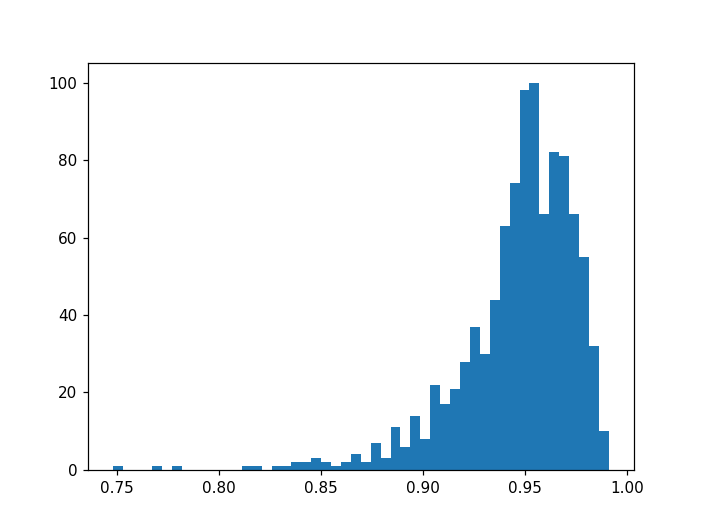

In [33]:
plt.figure()
plt.hist(scores.cpu().numpy(), bins=50);

In [22]:
scores.max()

tensor(0.9927, device='cuda:0')

In [36]:
# util.plot_imgs(out['observation']);

In [37]:
# util.plot_imgs(out['reconstruction']);

In [217]:
from torch import distributions as dist

In [22]:
space = spaces.Periodic()
space

Periodic(1)

In [69]:
N = 10000

In [251]:
D = 2
mu = [-4,0.]
sigma = 1.

mu, sigma = torch.as_tensor(mu), torch.as_tensor(sigma)
mu = mu.view(1, -1)
sigma = sigma.expand_as(mu)
mu.shape, sigma.shape

(torch.Size([1, 2]), torch.Size([1, 2]))

In [252]:
samples = torch.randn(N,D)*sigma + mu
samples.shape

torch.Size([10000, 2])

In [253]:
theta = space.compress(samples)
theta.shape

torch.Size([10000, 1])

In [254]:
# # plt.figure()
# util.plot_distribs(theta.t(), cut=0);

In [255]:
plt.figure()
nbins = 50
plt.hist(theta.squeeze().numpy(), color='C0', bins=nbins);
plt.hist(theta.squeeze().numpy()+1, color='C9', bins=nbins);
plt.hist(theta.squeeze().numpy()-1, color='C9', bins=nbins);
plt.xlim(-0.08, 1.08);
theta.std().item()*2*180

<IPython.core.display.Javascript object>

14.865518510341644

In [257]:
torch.Tensor.mro()

[torch.Tensor, torch._C._TensorBase, object]

In [258]:
torch.FloatTensor.mro()

[torch.FloatTensor, object]

In [259]:
torch.LongTensor.mro()

[torch.LongTensor, object]

In [223]:
loc, conc = torch.tensor([0.]), torch.tensor([0.])
loc.requires_grad = True
conc.requires_grad = True

In [218]:
m = dist.VonMises(loc, conc)

In [228]:
x = m.rsample((100,))
x.shape

NotImplementedError: 

In [265]:
tbl = []

R = 10

Ns = torch.logspace(1,6,10).long()
Ns = torch.linspace(10,10**4,5).long()

rho = 0.0
rhos = torch.linspace(0.,0.9,10)


# Ns = [1000]
# rhos = [0.]
for rho in rhos:
    rs = []
    for N in Ns:
        row = []
        for _ in range(R):
            x = torch.randn(N).pow(2)
#             row.append(x.norm().item())
            y = torch.randn(N).pow(2)*(1-rho) + x*rho
            row.append((x.div(x.norm())@y.div(y.norm())).item())
        rs.append(row)
    tbl.append(rs)
tbl = torch.as_tensor(tbl)
tbl.shape

torch.Size([10, 5, 10])

In [266]:
plt.figure()
# plt.plot(Ns.numpy(), tbl.mean(1).mean(-1));
plt.plot(rhos.view(-1,1).numpy(), tbl.mean(-1));

<IPython.core.display.Javascript object>

In [258]:
tbl.mean(-1).mean(-1)

tensor([0.7561, 0.7916, 0.8336, 0.8715, 0.9066, 0.9356, 0.9586, 0.9779, 0.9905, 0.9977])

In [267]:
hash(1)

1

In [270]:
hash((1,1))

8389048192121911274